In [ ]:
!pip install pytorch-lightning -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
import torch.nn.functional as F
import torchvision.datasets as dsets
import torch.utils.data as data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [ ]:
def save_model_as_pickle(model, model_name):
  with open(f'/content/drive/MyDrive/LMU_DL_A3_Q1/Saves/{model_name}', 'wb') as pickle_file:
    pickle.dump(model, pickle_file)

def load_model_from_pickle(model_name):
  with open(f'/content/drive/MyDrive/LMU_DL_A3_Q1/Saves/{model_name}', 'rb') as pickle_file:
    return pickle.load(pickle_file)

In [ ]:
with open('/content/drive/MyDrive/LMU_DL_A3_Q1/Data/permutedMNIST.pickle', 'rb') as pickle_file:
  permutedMNIST = pickle.load(pickle_file)

with open('/content/drive/MyDrive/LMU_DL_A3_Q1/Data/sequentialMNIST.pickle', 'rb') as pickle_file:
  sequentialMNIST = pickle.load(pickle_file)

In [ ]:
sequential_X = sequentialMNIST['train']['images']
sequential_y = sequentialMNIST['train']['labels']
permuted_X = permutedMNIST['train']['images']
permuted_y = permutedMNIST['train']['labels']
sequential_X = sequential_X/255
permuted_X = permuted_X/255

# Stratified 80-20 split into train and validation sets
from sklearn.model_selection import train_test_split

train_sequential_X, val_sequential_X, train_sequential_y, val_sequential_y = train_test_split(sequential_X, sequential_y, test_size=0.2, stratify=sequential_y, random_state=42)
train_permuted_X, val_permuted_X, train_permuted_y, val_permuted_y = train_test_split(permuted_X, permuted_y, test_size=0.2, stratify=permuted_y, random_state=42)

# Check Shapes
print('Sequential MNIST')
print('Train X Shape: ', train_sequential_X.shape)
print('Train y Shape: ', train_sequential_y.shape)
print('Validation X Shape: ', val_sequential_X.shape)
print('Validation y Shape: ', val_sequential_y.shape)

print('Permuted MNIST')
print('Train X Shape: ', train_permuted_X.shape)
print('Train y Shape: ', train_permuted_y.shape)
print('Validation X Shape: ', val_permuted_X.shape)
print('Validation y Shape: ', val_permuted_y.shape)

Sequential MNIST
Train X Shape:  (48000, 784, 1)
Train y Shape:  (48000,)
Validation X Shape:  (12000, 784, 1)
Validation y Shape:  (12000,)
Permuted MNIST
Train X Shape:  (48000, 784, 1)
Train y Shape:  (48000,)
Validation X Shape:  (12000, 784, 1)
Validation y Shape:  (12000,)


In [ ]:
# loop and check labels are same for each split

for i in range(len(train_sequential_y)):
    assert np.array_equal(train_sequential_y[i], train_permuted_y[i])

for i in range(len(val_sequential_y)):
    assert np.array_equal(val_sequential_y[i], val_permuted_y[i])

### 1. Visualize 3 Random Images

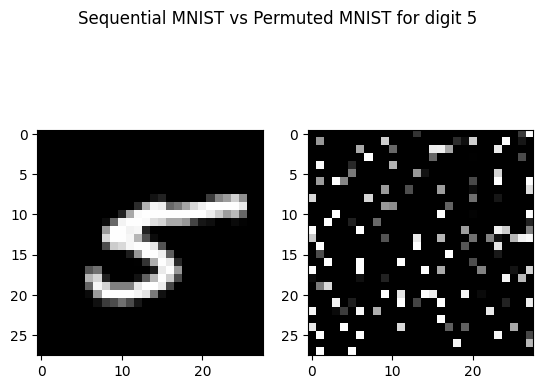

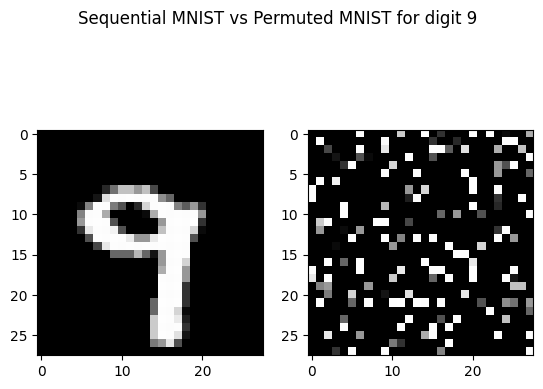

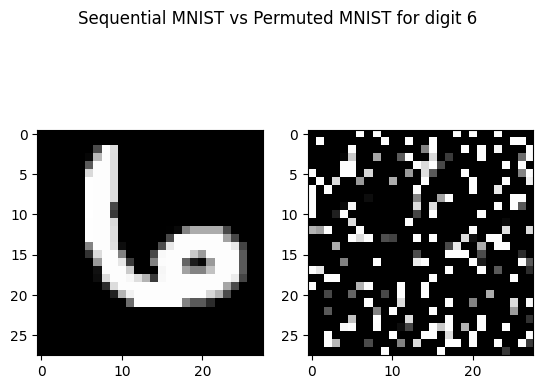

In [ ]:
for i in range(3):
    # Set Seed
    np.random.seed(i)
    # Choose a random image
    random_index = np.random.randint(0, len(train_sequential_X))
    # Plot the image at the random index from both datasets
    plt.subplot(1, 2, 1)
    plt.imshow(train_sequential_X[random_index].reshape(28,28), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(train_permuted_X[random_index].reshape(28,28), cmap='gray')
    plt.suptitle('Sequential MNIST vs Permuted MNIST for digit {}'.format(train_sequential_y[random_index]))
    plt.show()

### 2. Modelling

In [ ]:
input_size = 784
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 50
learning_rate = 0.0001

In [ ]:
# Define the LightningModule
class RNNModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.train_loss = []
        self.train_acc = []
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss_step = []
        self.val_acc_step = []
        self.val_loss = []
        self.val_acc = []
        self.clf_report = ""

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('train_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('train_accuracy', accuracy)
        self.train_loss_step.append(loss.item())
        self.train_acc_step.append(accuracy)
        return {"loss": loss}
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('val_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('val_accuracy', accuracy)
        self.val_loss_step.append(loss.item())
        self.val_acc_step.append(accuracy)
        return {"val_loss": loss}

    def on_train_epoch_end(self):
        self.train_loss.append(self.train_loss_step[-1])
        self.train_acc.append(self.train_acc_step[-1])
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss.append(self.val_loss_step[-1])
        self.val_acc.append(self.val_acc_step[-1])
        self.val_loss_step = []
        self.val_acc_step = []

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('test_accuracy', accuracy)
        return {"test_accuracy": accuracy}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
        
# Define the LightningDataModule
class SequentialDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, train_sequential_X, val_sequential_X, train_sequential_y, val_sequential_y):
        super(SequentialDataModule, self).__init__()
        self.batch_size = batch_size
        self.train_sequential_X = train_sequential_X
        self.val_sequential_X = val_sequential_X
        self.train_sequential_y = train_sequential_y
        self.val_sequential_y = val_sequential_y
        
    def prepare_data(self):
        # No data download required
        pass
        
    def setup(self, stage=None):
        self.train_dataset = data.TensorDataset(torch.Tensor(self.train_sequential_X), torch.Tensor(self.train_sequential_y))
        self.val_dataset = data.TensorDataset(torch.Tensor(self.val_sequential_X), torch.Tensor(self.val_sequential_y))
        
    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        # Use Val for Testing
        return torch.utils.data.DataLoader(dataset=self.val_dataset, batch_size=self.batch_size, shuffle=False)


class PermutedMNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, train_permuted_X, val_permuted_X, train_permuted_y, val_permuted_y):
        super(PermutedMNISTDataModule, self).__init__()
        self.batch_size = batch_size
        self.train_permuted_X = train_permuted_X
        self.val_permuted_X = val_permuted_X
        self.train_permuted_y = train_permuted_y
        self.val_permuted_y = val_permuted_y
        
    def prepare_data(self):
        # No data download required
        pass
        
    def setup(self, stage=None):
        self.train_dataset = data.TensorDataset(torch.Tensor(self.train_permuted_X), torch.Tensor(self.train_permuted_y))
        self.val_dataset = data.TensorDataset(torch.Tensor(self.val_permuted_X), torch.Tensor(self.val_permuted_y))
        
    def train_dataloader(self):
        train_dataloader = torch.utils.data.DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True)
        return train_dataloader
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset=self.val_dataset, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        # Use Val for Testing
        return torch.utils.data.DataLoader(dataset=self.val_dataset, batch_size=self.batch_size, shuffle=False)

In [ ]:
# Define the LightningModule
class RNNModel_Deeper(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel_Deeper, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.train_loss = []
        self.train_acc = []
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss_step = []
        self.val_acc_step = []
        self.val_loss = []
        self.val_acc = []
        self.clf_report = ""
        # Add more LSTM layers and skip connections
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size * 3, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)
        out, _ = self.rnn(x, (h0, c0))
        attention_weights = self.attention(out)
        attended_out = torch.sum(out * attention_weights, dim=1)

        # Add skip connection
        out = self.fc1(attended_out)
        out = torch.cat([out, attended_out], dim=1)
        out = self.fc2(out)
        return out
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('train_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('train_accuracy', accuracy)
        self.train_loss_step.append(loss.item())
        self.train_acc_step.append(accuracy)
        return {"loss": loss}
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('val_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('val_accuracy', accuracy)
        self.val_loss_step.append(loss.item())
        self.val_acc_step.append(accuracy)
        return {"val_loss": loss}

    def on_train_epoch_end(self):
        self.train_loss.append(self.train_loss_step[-1])
        self.train_acc.append(self.train_acc_step[-1])
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss.append(self.val_loss_step[-1])
        self.val_acc.append(self.val_acc_step[-1])
        self.val_loss_step = []
        self.val_acc_step = []

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('test_accuracy', accuracy)
        return {"test_accuracy": accuracy}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [ ]:
# Define the LightningModule
class RNNModel_Deeper_GRU(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel_Deeper_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.train_loss = []
        self.train_acc = []
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss_step = []
        self.val_acc_step = []
        self.val_loss = []
        self.val_acc = []
        self.clf_report = ""
        # Add more GRU layers and skip connections
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size * 3, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)
        out, _ = self.rnn(x, h0)
        attention_weights = self.attention(out)
        attended_out = torch.sum(out * attention_weights, dim=1)

        # Add skip connection
        out = self.fc1(attended_out)
        out = torch.cat([out, attended_out], dim=1)
        out = self.fc2(out)
        return out
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('train_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('train_accuracy', accuracy)
        self.train_loss_step.append(loss.item())
        self.train_acc_step.append(accuracy)
        return {"loss": loss}
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('val_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('val_accuracy', accuracy)
        self.val_loss_step.append(loss.item())
        self.val_acc_step.append(accuracy)
        return {"val_loss": loss}

    def on_train_epoch_end(self):
        self.train_loss.append(self.train_loss_step[-1])
        self.train_acc.append(self.train_acc_step[-1])
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss.append(self.val_loss_step[-1])
        self.val_acc.append(self.val_acc_step[-1])
        self.val_loss_step = []
        self.val_acc_step = []

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('test_accuracy', accuracy)
        return {"test_accuracy": accuracy}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [ ]:
# Define the LightningModule
class RNNModel_EvenDeeper(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel_EvenDeeper, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.train_loss = []
        self.train_acc = []
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss_step = []
        self.val_acc_step = []
        self.val_loss = []
        self.val_acc = []
        self.clf_report = ""
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size * 3, hidden_size)
        self.fc3 = nn.Linear(hidden_size * 3, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)
        out, _ = self.rnn(x, (h0, c0))
        attention_weights = self.attention(out)
        attended_out = torch.sum(out * attention_weights, dim=1)

        # Add skip connection
        out = self.dropout(self.relu(self.fc1(attended_out)))
        out = torch.cat([out, attended_out], dim=1)
        out = self.dropout(self.relu(self.fc2(out)))
        out = torch.cat([out, attended_out], dim=1)
        out = self.fc3(out)
        return out
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('train_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('train_accuracy', accuracy)
        self.train_loss_step.append(loss.item())
        self.train_acc_step.append(accuracy)
        return {"loss": loss}
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('val_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('val_accuracy', accuracy)
        self.val_loss_step.append(loss.item())
        self.val_acc_step.append(accuracy)
        return {"val_loss": loss}

    def on_train_epoch_end(self):
        self.train_loss.append(self.train_loss_step[-1])
        self.train_acc.append(self.train_acc_step[-1])
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss.append(self.val_loss_step[-1])
        self.val_acc.append(self.val_acc_step[-1])
        self.val_loss_step = []
        self.val_acc_step = []

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('test_accuracy', accuracy)
        return {"test_accuracy": accuracy}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [ ]:
# Define the LightningModule
class RNNModel_T2(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel_T2, self).__init__()
        self.train_loss = []
        self.train_acc = []
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss_step = []
        self.val_acc_step = []
        self.val_loss = []
        self.val_acc = []
        self.clf_report = ""
        # Add more LSTM layers and skip connections
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.rnn2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size * 3, hidden_size)
        self.fc3 = nn.Linear(hidden_size * 3, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)
        out1, _ = self.rnn1(x, (h0, c0))
        attention_weights = self.attention(out1)
        attended_out1 = torch.sum(out1 * attention_weights, dim=1)
        out2, _ = self.rnn2(out1, (h0, c0))
        attention_weights = self.attention(out2)
        attended_out2 = torch.sum(out2 * attention_weights, dim=1)

        # Add skip connection
        out = self.dropout(self.relu(self.fc1(attended_out2)))
        out = torch.cat([out, attended_out2], dim=1)
        out = self.dropout(self.relu(self.fc2(out)))
        out = torch.cat([out, attended_out1], dim=1)
        out = self.fc3(out)
        return out
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('train_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('train_accuracy', accuracy)
        self.train_loss_step.append(loss.item())
        self.train_acc_step.append(accuracy)
        return {"loss": loss}
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('val_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('val_accuracy', accuracy)
        self.val_loss_step.append(loss.item())
        self.val_acc_step.append(accuracy)
        return {"val_loss": loss}

    def on_train_epoch_end(self):
        self.train_loss.append(self.train_loss_step[-1])
        self.train_acc.append(self.train_acc_step[-1])
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss.append(self.val_loss_step[-1])
        self.val_acc.append(self.val_acc_step[-1])
        self.val_loss_step = []
        self.val_acc_step = []

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('test_accuracy', accuracy)
        return {"test_accuracy": accuracy}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [ ]:
from torch.nn.modules import Conv2d
class RNNModel_T3(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel_T3, self).__init__()
        self.train_loss = []
        self.train_acc = []
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss_step = []
        self.val_acc_step = []
        self.val_loss = []
        self.val_acc = []
        self.clf_report = ""

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # Define the RNN layers
        self.rnn1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.rnn2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.rnn3 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # Define the attention layer
        self.attention1 = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )

        self.attention2 = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )

        self.attention3 = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )
        # Define the fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size * 3, hidden_size)
        self.fc3 = nn.Linear(hidden_size * 3, num_classes)

        # Define the dropout and activation functions
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)

        h1 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)
        c1 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)

        h2 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)
        c2 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)

        # Pass the input through the RNN layers
        out1, _ = self.rnn1(x, (h0, c0))
        attention_weights = self.attention1(out1)
        attended_out1 = torch.sum(out1 * attention_weights, dim=1)

        out2, _ = self.rnn2(out1, (h1, c1))
        attention_weights = self.attention2(out2)
        attended_out2 = torch.sum(out2 * attention_weights, dim=1)

        out3, _ = self.rnn3(out2, (h2, c2))
        attention_weights = self.attention3(out3)
        attended_out3 = torch.sum(out3 * attention_weights, dim=1)

        # Concatenate the attended outputs and add the skip connection
        out = self.dropout(self.relu(self.fc1(attended_out3)))
        out = torch.cat([out, attended_out3], dim=1)
        out = self.dropout(self.relu(self.fc2(out)))
        out = torch.cat([out, attended_out2], dim=1)
        out = self.fc3(out)

        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('train_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('train_accuracy', accuracy)
        self.train_loss_step.append(loss.item())
        self.train_acc_step.append(accuracy)
        return {"loss": loss}
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('val_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('val_accuracy', accuracy)
        self.val_loss_step.append(loss.item())
        self.val_acc_step.append(accuracy)
        return {"val_loss": loss}

    def on_train_epoch_end(self):
        self.train_loss.append(self.train_loss_step[-1])
        self.train_acc.append(self.train_acc_step[-1])
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss.append(self.val_loss_step[-1])
        self.val_acc.append(self.val_acc_step[-1])
        self.val_loss_step = []
        self.val_acc_step = []

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('test_accuracy', accuracy)
        return {"test_accuracy": accuracy}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [ ]:
from torch.nn.modules import Conv2d
class RNNModel_T4(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel_T3, self).__init__()
        self.train_loss = []
        self.train_acc = []
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss_step = []
        self.val_acc_step = []
        self.val_loss = []
        self.val_acc = []
        self.clf_report = ""

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # Define the RNN layers
        self.rnn1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.rnn2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.rnn3 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # Define the attention layers
        self.attention1 = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )

        self.attention2 = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )

        self.attention3 = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )

        # Define the fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size * 4, hidden_size)
        self.fc3 = nn.Linear(hidden_size * 3, num_classes)

        # Define the dropout and activation functions
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)

        h1 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)
        c1 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)

        h2 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)
        c2 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device=self.device)

        # Pass the input through the RNN layers
        out1, _ = self.rnn1(x, (h0, c0))
        attention_weights1 = self.attention1(out1)
        attended_out1 = torch.sum(out1 * attention_weights1, dim=1)

        out2, _ = self.rnn2(torch.cat([out1, attended_out1], dim=2), (h1, c1))
        attention_weights2 = self.attention2(out2)
        attended_out2 = torch.sum(out2 * attention_weights2, dim=1)
        out3, _ = self.rnn3(torch.cat([out2, attended_out2], dim=2), (h2, c2))
        attention_weights3 = self.attention3(out3)
        attended_out3 = torch.sum(out3 * attention_weights3, dim=1)

        # Pass the output through the fully connected layers
        fc1_out = self.relu(self.fc1(attended_out3))
        fc2_out = self.relu(self.fc2(torch.cat([attended_out1, attended_out2, fc1_out], dim=1)))
        out = self.fc3(torch.cat([fc1_out, fc2_out, attended_out3], dim=1))

        return out
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('train_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('train_accuracy', accuracy)
        self.train_loss_step.append(loss.item())
        self.train_acc_step.append(accuracy)
        return {"loss": loss}
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        self.log('val_loss', loss)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('val_accuracy', accuracy)
        self.val_loss_step.append(loss.item())
        self.val_acc_step.append(accuracy)
        return {"val_loss": loss}

    def on_train_epoch_end(self):
        self.train_loss.append(self.train_loss_step[-1])
        self.train_acc.append(self.train_acc_step[-1])
        self.train_loss_step = []
        self.train_acc_step = []
        self.val_loss.append(self.val_loss_step[-1])
        self.val_acc.append(self.val_acc_step[-1])
        self.val_loss_step = []
        self.val_acc_step = []

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(0, 2, 1)  # permute to [batch_size, input_size, seq_len]
        x = x.to(self.device)
        y = y.to(torch.long).to(self.device) # cast y to long
        outputs = self(x)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        accuracy = correct / total
        self.log('test_accuracy', accuracy)
        return {"test_accuracy": accuracy}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [ ]:
# import matplotlib.pyplot as plt

# # Create the data module and the model, and train the model with early stopping
# data_module_sequential = SequentialDataModule(batch_size, train_sequential_X, val_sequential_X, train_sequential_y, val_sequential_y)
# model_sequential = RNNModel_Deeper(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)

# # Define the EarlyStopping callback
# early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# # Create a PyTorch Lightning Trainer
# trainer_sequential = pl.Trainer(max_epochs=num_epochs, callbacks=[early_stop_callback])

# # Train the model
# for epoch in range(num_epochs):
#     trainer_sequential.fit(model_sequential, datamodule=data_module_sequential)
    
# # Test the model
# trainer_sequential.test(datamodule=data_module_sequential)

In [ ]:
# save_model_as_pickle(model_sequential, "sequential_save")
model_sequential = load_model_from_pickle("sequential_save")

In [ ]:
test_dataset_sequential = TensorDataset(torch.Tensor(val_sequential_X), torch.Tensor(val_sequential_y))
test_loader_sequential = DataLoader(test_dataset_sequential, batch_size=batch_size, shuffle=False)
num_samples_sequential = len(test_dataset_sequential)  # get number of samples in dataset

# Evaluate model on test set
predictions_sequential = []
true_labels_sequential = []
with torch.no_grad():
    for batch in test_loader_sequential:
        x, y = batch
        x = x.view(100, 1, 784)
        output_sequential = model_sequential(x)
        _, predicted_sequential = torch.max(output_sequential.data, 1)
        predictions_sequential.extend(predicted_sequential.cpu().numpy())
        true_labels_sequential.extend(y.cpu().numpy())

# Calculate classification report
report_sequential = classification_report(true_labels_sequential, predictions_sequential)
print(report_sequential)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1185
         1.0       0.98      0.99      0.98      1348
         2.0       0.97      0.97      0.97      1192
         3.0       0.98      0.96      0.97      1226
         4.0       0.98      0.99      0.98      1168
         5.0       0.97      0.97      0.97      1084
         6.0       0.98      0.98      0.98      1184
         7.0       0.98      0.98      0.98      1253
         8.0       0.94      0.98      0.96      1170
         9.0       0.98      0.97      0.97      1190

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



In [ ]:
def plot_train_val(train_loss, val_loss, type):
  epochs = len(val_loss)
  plt.plot(train_loss, label = f"Train {type}")
  plt.plot(val_loss, label = f"Val {type}")
  plt.legend()

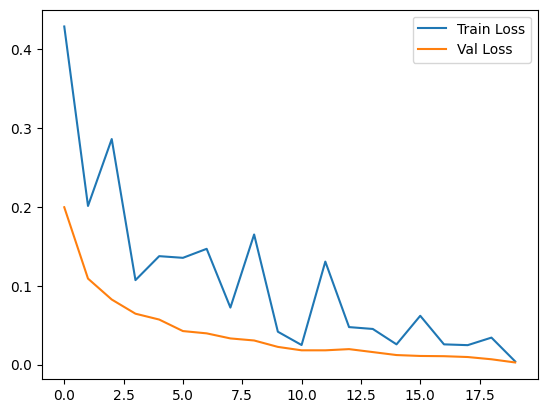

In [ ]:
plot_train_val(model_sequential.train_loss, model_sequential.val_loss, "Loss")

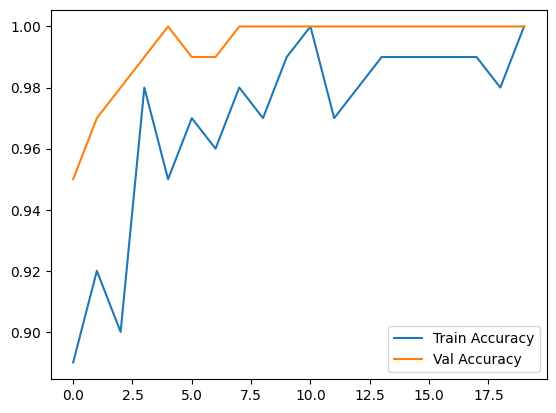

In [ ]:
plot_train_val(model_sequential.train_acc, model_sequential.val_acc, "Accuracy")

In [ ]:
# # Create the data module and the model, and train the model with early stopping
# data_module_permuted = PermutedMNISTDataModule(batch_size, train_permuted_X, val_permuted_X, train_permuted_y, val_permuted_y)
# model_permuted = RNNModel_Deeper(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)

# # Define the EarlyStopping callback
# early_stop_callback_permuted = pl.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# # Create a PyTorch Lightning Trainer
# trainer_permuted = pl.Trainer(max_epochs=num_epochs, callbacks=[early_stop_callback_permuted])

# # Train the model
# trainer_permuted.fit(model_permuted, datamodule=data_module_permuted)

# # Test the model
# trainer_permuted.test(datamodule=data_module_permuted)

In [ ]:
# save_model_as_pickle(model_permuted, "permuted_save")
model_permuted = load_model_from_pickle("permuted_save")

In [ ]:
test_dataset_permuted = TensorDataset(torch.Tensor(val_permuted_X), torch.Tensor(val_permuted_y))
test_loader_permuted = DataLoader(test_dataset_permuted, batch_size=batch_size, shuffle=False)
num_samples_permuted = len(test_dataset_permuted)  # get number of samples in dataset

# Evaluate model on test set
predictions_permuted = []
true_labels_permuted = []
with torch.no_grad():
    for batch in test_loader_permuted:
        x, y = batch
        x = x.view(100, 1, 784)
        output_permuted = model_permuted(x)
        _, predicted_permuted = torch.max(output_permuted.data, 1)
        predictions_permuted.extend(predicted_permuted.cpu().numpy())
        true_labels_permuted.extend(y.cpu().numpy())

# Calculate classification report
report_permuted = classification_report(true_labels_permuted, predictions_permuted)
print(report_permuted)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1185
         1.0       0.98      0.99      0.99      1348
         2.0       0.97      0.98      0.97      1192
         3.0       0.98      0.96      0.97      1226
         4.0       0.98      0.98      0.98      1168
         5.0       0.97      0.97      0.97      1084
         6.0       0.99      0.98      0.98      1184
         7.0       0.98      0.97      0.98      1253
         8.0       0.97      0.97      0.97      1170
         9.0       0.97      0.97      0.97      1190

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



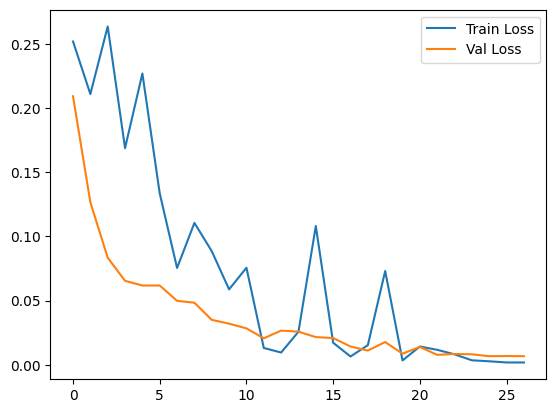

In [ ]:
plot_train_val(model_permuted.train_loss, model_permuted.val_loss, "Loss")

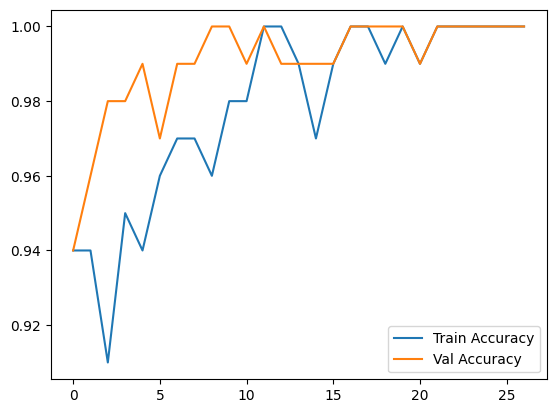

In [ ]:
plot_train_val(model_permuted.train_acc, model_permuted.val_acc, "Accuracy")

## Combine Train and Val

### Sequential

In [ ]:
# import matplotlib.pyplot as plt

# # Create the data module and the model, and train the model with early stopping
# data_module_sequential_full_data = SequentialDataModule(batch_size, sequential_X, val_sequential_X, sequential_y, val_sequential_y)
# model_sequential_full_data = RNNModel_Deeper(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)

# # Define the EarlyStopping callback
# early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# # Create a PyTorch Lightning Trainer
# trainer_sequential_full_data = pl.Trainer(max_epochs=num_epochs, callbacks=[early_stop_callback])

# # Train the model
# for epoch in range(num_epochs):
#     trainer_sequential_full_data.fit(model_sequential_full_data, datamodule=data_module_sequential_full_data)
    
# # Test the model
# trainer_sequential_full_data.test(datamodule=data_module_sequential_full_data)

In [ ]:
# save_model_as_pickle(model_sequential_full_data, "model_sequential_full_data_save")
model_sequential_full_data = load_model_from_pickle("model_sequential_full_data_save")

In [ ]:
test_dataset_sequential = TensorDataset(torch.Tensor(val_sequential_X), torch.Tensor(val_sequential_y))
test_loader_sequential = DataLoader(test_dataset_sequential, batch_size=batch_size, shuffle=False)
num_samples_sequential = len(test_dataset_sequential)  # get number of samples in dataset

# Evaluate model on test set
predictions_sequential = []
true_labels_sequential = []
with torch.no_grad():
    for batch in test_loader_sequential:
        x, y = batch
        x = x.view(100, 1, 784)
        output_sequential = model_sequential_full_data(x)
        _, predicted_sequential = torch.max(output_sequential.data, 1)
        predictions_sequential.extend(predicted_sequential.cpu().numpy())
        true_labels_sequential.extend(y.cpu().numpy())

# Calculate classification report
report_sequential = classification_report(true_labels_sequential, predictions_sequential)
print(report_sequential)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1185
         1.0       1.00      1.00      1.00      1348
         2.0       1.00      1.00      1.00      1192
         3.0       1.00      1.00      1.00      1226
         4.0       1.00      1.00      1.00      1168
         5.0       1.00      1.00      1.00      1084
         6.0       1.00      1.00      1.00      1184
         7.0       1.00      1.00      1.00      1253
         8.0       1.00      1.00      1.00      1170
         9.0       1.00      1.00      1.00      1190

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000



### Permuted

In [ ]:
# # Create the data module and the model, and train the model with early stopping
# data_module_permuted_full_data = PermutedMNISTDataModule(batch_size, train_permuted_X, val_permuted_X, train_permuted_y, val_permuted_y)
# model_permuted_full_data = RNNModel_Deeper(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)

# # Define the EarlyStopping callback
# early_stop_callback_permuted = pl.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# # Create a PyTorch Lightning Trainer
# trainer_permuted_full_data = pl.Trainer(max_epochs=num_epochs, callbacks=[early_stop_callback_permuted])

# # Train the model
# trainer_permuted_full_data.fit(model_permuted_full_data, datamodule=data_module_permuted_full_data)

# # Test the model
# trainer_permuted_full_data.test(datamodule=data_module_permuted_full_data)

In [ ]:
# save_model_as_pickle(model_permuted_full_data, "model_permuted_full_data_save")
model_permuted_full_data = load_model_from_pickle("model_permuted_full_data_save")

In [ ]:
test_dataset_permuted = TensorDataset(torch.Tensor(val_permuted_X), torch.Tensor(val_permuted_y))
test_loader_permuted = DataLoader(test_dataset_permuted, batch_size=batch_size, shuffle=False)
num_samples_permuted = len(test_dataset_permuted)  # get number of samples in dataset

# Evaluate model on test set
predictions_permuted = []
true_labels_permuted = []
with torch.no_grad():
    for batch in test_loader_permuted:
        x, y = batch
        x = x.view(100, 1, 784)
        output_permuted = model_permuted_full_data(x)
        _, predicted_permuted = torch.max(output_permuted.data, 1)
        predictions_permuted.extend(predicted_permuted.cpu().numpy())
        true_labels_permuted.extend(y.cpu().numpy())

# Calculate classification report
report_permuted = classification_report(true_labels_permuted, predictions_permuted)
print(report_permuted)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1185
         1.0       0.99      0.99      0.99      1348
         2.0       0.96      0.98      0.97      1192
         3.0       0.98      0.96      0.97      1226
         4.0       0.98      0.98      0.98      1168
         5.0       0.97      0.98      0.97      1084
         6.0       0.99      0.98      0.98      1184
         7.0       0.98      0.97      0.98      1253
         8.0       0.96      0.97      0.96      1170
         9.0       0.97      0.97      0.97      1190

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



### Inference Pipeline

In [ ]:
def inference_pipeline(dataset, splitName, model_name, trained_on_val=True):
  data_X = dataset[splitName]['images']
  data_y = dataset[splitName]['labels']
  data_X = data_X/255
  model = None
  if model_name == "sequential":
    if trained_on_val:
      model = load_model_from_pickle("model_sequential_full_data_save")
    else:
      model = load_model_from_pickle("sequential_save")
  else:
    if trained_on_val:
      model = load_model_from_pickle("model_permuted_full_data_save")
    else:
      model = load_model_from_pickle("permuted_save")
  
  test_dataset = TensorDataset(torch.Tensor(data_X), torch.Tensor(data_y))
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  num_samples = len(test_dataset)  # get number of samples in dataset

  # Evaluate model on test set
  predictions = []
  true_labels = []
  with torch.no_grad():
      for batch in test_loader:
          x, y = batch
          x = x.view(100, 1, 784)
          output = model(x)
          _, predicted = torch.max(output.data, 1)
          predictions.extend(predicted.cpu().numpy())
          true_labels.extend(y.cpu().numpy())

  # Calculate classification report
  report_permuted = classification_report(true_labels, predictions)
  print(report_permuted)

In [ ]:
inference_pipeline(sequentialMNIST, "train", "sequential", True)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5923
         1.0       1.00      1.00      1.00      6742
         2.0       1.00      1.00      1.00      5958
         3.0       1.00      1.00      1.00      6131
         4.0       1.00      1.00      1.00      5842
         5.0       1.00      1.00      1.00      5421
         6.0       1.00      1.00      1.00      5918
         7.0       1.00      1.00      1.00      6265
         8.0       1.00      1.00      1.00      5851
         9.0       1.00      1.00      1.00      5949

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



In [ ]:
inference_pipeline(sequentialMNIST, "train", "sequential", False)

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      5923
         1.0       0.99      1.00      1.00      6742
         2.0       0.99      0.99      0.99      5958
         3.0       1.00      0.99      0.99      6131
         4.0       0.99      0.99      0.99      5842
         5.0       0.99      0.99      0.99      5421
         6.0       0.99      0.99      0.99      5918
         7.0       0.99      0.99      0.99      6265
         8.0       0.98      0.99      0.99      5851
         9.0       0.99      0.99      0.99      5949

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



In [ ]:
inference_pipeline(permutedMNIST, "train", "permuted", True)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5923
         1.0       1.00      1.00      1.00      6742
         2.0       0.99      0.99      0.99      5958
         3.0       1.00      0.99      0.99      6131
         4.0       0.99      0.99      0.99      5842
         5.0       0.99      1.00      0.99      5421
         6.0       1.00      1.00      1.00      5918
         7.0       1.00      0.99      0.99      6265
         8.0       0.99      0.99      0.99      5851
         9.0       0.99      0.99      0.99      5949

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



In [ ]:
inference_pipeline(permutedMNIST, "train", "permuted", False)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5923
         1.0       1.00      1.00      1.00      6742
         2.0       0.99      0.99      0.99      5958
         3.0       1.00      0.99      0.99      6131
         4.0       1.00      1.00      1.00      5842
         5.0       0.99      0.99      0.99      5421
         6.0       1.00      0.99      1.00      5918
         7.0       1.00      0.99      0.99      6265
         8.0       0.99      0.99      0.99      5851
         9.0       0.99      0.99      0.99      5949

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000

